In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
plt.style.use('ggplot')


In [4]:
# Read in data
df = pd.read_csv ('/Users/mustansirmurtazakaj/Desktop/pythonjupyter/Amazonreviews/Reviews.csv')
print(df.shape)
df = df.head(500)
print(df.shape)

(568454, 10)
(500, 10)


In [5]:
df['Text'].values[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

## EDA

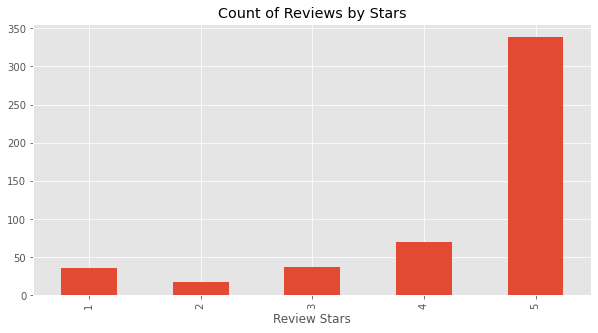

In [6]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Basic NLTK

In [7]:
example = df['Text'][50]
print(example)
import nltk
#nltk.download('punkt')

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [8]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [9]:
import nltk
#nltk.download('maxent_ne_chunker')
import nltk
#nltk.download('averaged_perceptron_tagger')
# pos = part of speech values
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [10]:
#nltk.download('words')
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


# Step 1. VADER Seniment Scoring

We will use NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the text.

- This uses a "bag of words" approach:
    1. Stop words are removed
    2. each word is scored and combined to a total score.

In [11]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

#nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

In [12]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [13]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [14]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [15]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [16]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [17]:
# Now we have sentiment score and metadata
vaders
vaders.to_csv('vaders.csv', index=True)  # Set index=False to exclude the DataFrame index from the CSV file


## Plot VADER results

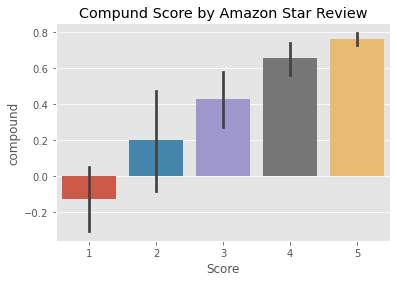

In [18]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

In [34]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar. And it is a tiny mouthful of heaven. Not too chewy, and very flavorful. I highly recommend this yummy treat. If you are familiar with the story of C.S. Lewis' ""The Lion, The Witch, and The Wardrobe"" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch."
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The flavor is very medicinal.
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


In [31]:
pd.options.display.max_colwidth = 100000000

# Sort the DataFrame by 'compound' in descending order to get top-rated products
top_rated_products = vaders.sort_values(by='compound', ascending=False)

# Sort the DataFrame by 'compound' in ascending order to get bottom-rated products
bottom_rated_products = vaders.sort_values(by='compound', ascending=True)

# Print the top-rated products
print("Top-rated products:")
top_rated_products.head(10)[['Id', 'ProductId', 'compound','Summary']]

Top-rated products:


,Id,ProductId,compound,Summary
82,83,B003ZFRKGO,0.9957,Forget Molecular Gastronomy - this stuff rockes a coffee creamer!
112,113,B0037LW78C,0.9946,My every day green tea
186,187,B000NY8ODS,0.9944,"Make a fresh fruit tart, light and beautiful"
237,238,B000WFRMRW,0.9936,High Quality... But it gave my dog wicked gas..
479,480,B000G6RYNE,0.9935,Great Chip!
467,468,B000G6RYNE,0.9926,"Crunchy, salty, sweet...finally, a Superbowl snack that scooores!"
370,371,B002O3VHXU,0.9923,A saving grace for Green Mountain Coffee...
383,384,B000UXA3L8,0.9913,"Excellent flavor, mostly large pieces"
28,29,B00144C10S,0.9913,YUMMY!
173,174,B0081XN2HQ,0.9901,"Fluffy, Soft, Delicious and Sugary Sweet"


In [32]:
# Print the bottom-rated products
print("Bottom-rated products:")
bottom_rated_products.head(10)[['Id', 'ProductId', 'compound','Summary']]

Bottom-rated products:


,Id,ProductId,compound,Summary
213,214,B0009XLVGA,-0.9726,CHANGED FORMULA MAKES CATS SICK!!!!
263,264,B000LKZK7C,-0.9218,Manufacturing Problems Diminish Product
67,68,B005DUM9UQ,-0.9116,Taste is not so good.
403,404,B006CGURWM,-0.9058,disappointing
305,306,B001UJEN6C,-0.9037,So awful I can barely describe
417,418,B000SEJ842,-0.8957,Look elsewhere for your whole grains
328,329,B003VTN95K,-0.8462,Better Packaging
52,53,B000G6RPMY,-0.8259,You'll go nuts over Ass-Kickin' Peanuts.
390,391,B003XT4AV0,-0.8174,Cat won't go near it!
169,170,B0064KO0BU,-0.7721,Banana Heads Not Banana Runts


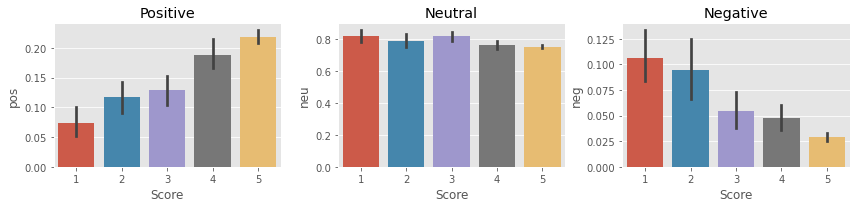

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()